<a href="https://colab.research.google.com/github/LaShawnSykes/Neural-Newsroom_G2_P3/blob/main/Copy_of_NeuralNewsroomModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Section 1: Setup and Imports
!pip install python-dotenv requests pandas

import os
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
import random
from dotenv import load_dotenv
from google.colab import files

In [ ]:
# Section 2: Guardian API Function
def fetch_guardian_articles(api_key, start_date, end_date):
    base_url = "https://content.guardianapis.com/search"
    sections = ['politics', 'business', 'technology', 'sport', 'culture', 'environment', 'science', 'world']
    all_articles = []

    def fetch_with_retry(params, max_retries=5):
        for attempt in range(max_retries):
            try:
                response = requests.get(base_url, params=params)
                if response.status_code == 200:
                    return response.json()
                elif response.status_code == 429:
                    wait_time = (2 ** attempt) + random.random()
                    print(f"Rate limit hit. Waiting for {wait_time:.2f} seconds.")
                    time.sleep(wait_time)
                else:
                    response.raise_for_status()
            except requests.RequestException as e:
                print(f"Request failed: {e}")
                if attempt == max_retries - 1:
                    print("Max retries reached. Skipping this request.")
                    return None
                time.sleep(2 ** attempt)

    current_date = start_date
    while current_date <= end_date:
        for section in sections:
            page = 1
            while True:
                params = {
                    'api-key': api_key,
                    'section': section,
                    'from-date': current_date.strftime("%Y-%m-%d"),
                    'to-date': (current_date + timedelta(days=1)).strftime("%Y-%m-%d"),
                    'page': page,
                    'page-size': 50,
                    'show-fields': 'bodyText'
                }

                result = fetch_with_retry(params)
                if not result:
                    break

                articles = result['response']['results']
                if not articles:
                    break

                for article in articles:
                    all_articles.append({
                        'title': article['webTitle'],
                        'body': article.get('fields', {}).get('bodyText', ''),
                        'section': section,
                        'date': article['webPublicationDate']
                    })

                print(f"Fetched {len(articles)} articles for {section} on {current_date.strftime('%Y-%m-%d')}")

                if page >= result['response']['pages']:
                    break

                page += 1
                time.sleep(1)  # Respect rate limits

            time.sleep(2)  # Pause between sections

        current_date += timedelta(days=1)
        time.sleep(5)  # Pause between days

    return pd.DataFrame(all_articles)

In [ ]:
# Section 3: Main Execution
# Upload .env file
print("Please upload your .env file containing the GUARDIAN_API_KEY")
uploaded = files.upload()

# Load API key from .env file
load_dotenv(next(iter(uploaded)))
api_key = os.getenv('GUARDIAN_API_KEY')

if not api_key:
    raise ValueError("API key not found. Make sure your .env file contains GUARDIAN_API_KEY")

# Set date range for fetching articles (adjust as needed)
end_date = datetime.now()
start_date = end_date - timedelta(days=7)  # Fetch last 7 days of data

print(f"Fetching articles from {start_date.date()} to {end_date.date()}")
df = fetch_guardian_articles(api_key, start_date, end_date)

# Save to CSV
csv_filename = 'guardian_articles.csv'
df.to_csv(csv_filename, index=False)
print(f"Saved {len(df)} articles to {csv_filename}")

# Display sample of the data
print("\nSample of fetched data:")
print(df.head())

# Display dataset info
print("\nDataset Info:")
print(df.info())

# Provide download link for the CSV file
files.download(csv_filename)

Please upload your .env file containing the GUARDIAN_API_KEY


Saving .env to .env
Fetching articles from 2024-07-23 to 2024-07-30
Fetched 21 articles for politics on 2024-07-23
Fetched 17 articles for business on 2024-07-23
Fetched 9 articles for technology on 2024-07-23
Fetched 49 articles for sport on 2024-07-23
Fetched 5 articles for culture on 2024-07-23
Fetched 20 articles for environment on 2024-07-23
Fetched 6 articles for science on 2024-07-23
Fetched 34 articles for world on 2024-07-23
Fetched 21 articles for politics on 2024-07-24
Fetched 22 articles for business on 2024-07-24
Fetched 5 articles for technology on 2024-07-24
Fetched 50 articles for sport on 2024-07-24
Fetched 12 articles for sport on 2024-07-24
Fetched 6 articles for culture on 2024-07-24
Fetched 21 articles for environment on 2024-07-24
Fetched 6 articles for science on 2024-07-24
Fetched 41 articles for world on 2024-07-24
Fetched 15 articles for politics on 2024-07-25
Fetched 18 articles for business on 2024-07-25
Fetched 4 articles for technology on 2024-07-25
Fetche

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Section 4A: Import Libraries and Load Data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load the data
df = pd.read_csv('guardian_articles.csv')
print("Data loaded. Shape:", df.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data loaded. Shape: (1252, 4)


In [ ]:
# Section 4B: Text Preprocessing

def preprocess_text(text):
    # Convert to string if not already
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['title'].fillna('') + ' ' + df['body'].fillna('')
df['processed_text'] = df['processed_text'].apply(preprocess_text)

print("Text preprocessing completed.")

Text preprocessing completed.


In [ ]:
# Section 4C: Encode Labels and Split Data

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['section'])

# Split the data
X = df['processed_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split completed.")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Data split completed.
Training samples: 1001
Testing samples: 251


In [ ]:
# Section 4D: Tokenize and Pad Sequences

max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

print("Tokenization and padding completed.")
print(f"Shape of padded training data: {X_train_pad.shape}")
print(f"Shape of padded testing data: {X_test_pad.shape}")

Tokenization and padding completed.
Shape of padded training data: (1001, 200)
Shape of padded testing data: (251, 200)


In [ ]:
# Section 4E: Convert Labels to Categorical

num_classes = len(label_encoder.classes_)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

print("Labels converted to categorical.")
print(f"Number of classes: {num_classes}")
print(f"Shape of categorical training labels: {y_train_cat.shape}")
print(f"Shape of categorical testing labels: {y_test_cat.shape}")

Labels converted to categorical.
Number of classes: 8
Shape of categorical training labels: (1001, 8)
Shape of categorical testing labels: (251, 8)


In [ ]:
# Section 5: Model Creation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define model architecture
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

print("Model created and compiled.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 200, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 1344456 (5.13 MB)
Trainable params: 134445

In [ ]:
# Section 6: Model Training

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

print("Model training completed.")

Epoch 1/20
25/25 [==============================] - 10s 142ms/step - loss: 1.8971 - accuracy: 0.3587 - val_loss: 1.7330 - val_accuracy: 0.3831
Epoch 2/20
 1/25 [>.............................] - ETA: 2s - loss: 1.6438 - accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 3s 109ms/step - loss: 1.3589 - accuracy: 0.5275 - val_loss: 1.2129 - val_accuracy: 0.5373
Epoch 3/20
25/25 [==============================] - 3s 133ms/step - loss: 0.9091 - accuracy: 0.6550 - val_loss: 1.0752 - val_accuracy: 0.6368
Epoch 4/20
25/25 [==============================] - 2s 94ms/step - loss: 0.7676 - accuracy: 0.7113 - val_loss: 1.0449 - val_accuracy: 0.6119
Epoch 5/20
25/25 [==============================] - 2s 72ms/step - loss: 0.6560 - accuracy: 0.7412 - val_loss: 0.9548 - val_accuracy: 0.6866
Epoch 6/20
25/25 [==============================] - 2s 87ms/step - loss: 0.5185 - accuracy: 0.8100 - val_loss: 0.9711 - val_accuracy: 0.7164
Epoch 7/20
25/25 [==============================] - 2s 65ms/step - loss: 0.4308 - accuracy: 0.8313 - val_loss: 0.9831 - val_accuracy: 0.7214
Epoch 8/20
25/25 [==============================] - 1s 61ms/step - loss: 0.3484 - accuracy: 0.8763 - val_loss: 0.9390 - val_accuracy: 0.7612
Epoch 9/20
25/25 [====

In [ ]:
# Section 5B: Improved Model Creation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define improved model architecture
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
    BatchNormalization(),
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

print("Improved model created and compiled.")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          98816     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 200, 128)          512       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                     

In [ ]:
# Section 6: Model Training (for improved model)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_improved_model.h5', save_best_only=True)

# Train the model
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=30,  # Increased from 20 to give more time for learning
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

print("Improved model training completed.")

Epoch 1/30
25/25 [==============================] - 13s 197ms/step - loss: 9.9887 - accuracy: 0.1488 - val_loss: 8.4746 - val_accuracy: 0.3632
Epoch 2/30
25/25 [==============================] - 4s 152ms/step - loss: 9.3388 - accuracy: 0.2150 - val_loss: 8.2995 - val_accuracy: 0.3632
Epoch 3/30
25/25 [==============================] - 3s 122ms/step - loss: 8.6845 - accuracy: 0.2738 - val_loss: 8.1426 - val_accuracy: 0.3632
Epoch 4/30
25/25 [==============================] - 3s 107ms/step - loss: 8.3050 - accuracy: 0.3150 - val_loss: 7.9975 - val_accuracy: 0.3632
Epoch 5/30
25/25 [==============================] - 3s 104ms/step - loss: 7.9888 - accuracy: 0.3550 - val_loss: 7.8619 - val_accuracy: 0.3632
Epoch 6/30
25/25 [==============================] - 3s 140ms/step - loss: 7.4369 - accuracy: 0.4650 - val_loss: 7.7298 - val_accuracy: 0.3632
Epoch 7/30
25/25 [==============================] - 2s 90ms/step - loss: 7.1247 - accuracy: 0.4825 - val_loss: 7.5966 - val_accuracy: 0.3632
Epoch 

In [ ]:
# Section 5C: CNN-LSTM Hybrid Model Creation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

# Define model architecture
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    LSTM(64, return_sequences=True),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

print("CNN-LSTM Hybrid model created and compiled.")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           41024     
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 128)           41088     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 11, 128)           0         
 g1D)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 11, 64)           

In [ ]:
# Section 6C: CNN-LSTM Hybrid Model Training

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_lstm_model.h5', save_best_only=True)

# Train the model
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

print("CNN-LSTM Hybrid model training completed.")

Epoch 1/30
25/25 [==============================] - 9s 153ms/step - loss: 1.8975 - accuracy: 0.3275 - val_loss: 1.7710 - val_accuracy: 0.3632
Epoch 2/30
25/25 [==============================] - 3s 124ms/step - loss: 1.6337 - accuracy: 0.3925 - val_loss: 1.5012 - val_accuracy: 0.3632
Epoch 3/30
25/25 [==============================] - 2s 102ms/step - loss: 1.2213 - accuracy: 0.5612 - val_loss: 1.2224 - val_accuracy: 0.5473
Epoch 4/30
25/25 [==============================] - 2s 78ms/step - loss: 0.9487 - accuracy: 0.6400 - val_loss: 1.0694 - val_accuracy: 0.6269
Epoch 5/30
25/25 [==============================] - 1s 52ms/step - loss: 0.7168 - accuracy: 0.7375 - val_loss: 0.9714 - val_accuracy: 0.6816
Epoch 6/30
25/25 [==============================] - 2s 62ms/step - loss: 0.5058 - accuracy: 0.8275 - val_loss: 0.9079 - val_accuracy: 0.7512
Epoch 7/30
25/25 [==============================] - 1s 52ms/step - loss: 0.3617 - accuracy: 0.8712 - val_loss: 1.2209 - val_accuracy: 0.6915
Epoch 8/30

In [ ]:
# Section 5D: Improved CNN-LSTM Hybrid Model Creation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 10))

# Define model architecture
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

print("Improved CNN-LSTM Hybrid model created and compiled.")

# Section 6D: Improved CNN-LSTM Hybrid Model Training

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_improved_cnn_lstm_model.h5', save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=40,  # Increased epochs to allow for learning rate decay
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

print("Improved CNN-LSTM Hybrid model training completed.")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 196, 64)           41024     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 45, 128)           41088     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 11, 128)           0         
 g1D)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 11, 64)           

In [ ]:
# Section 5E: Refined CNN-LSTM Hybrid Model Creation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
import tensorflow as tf

def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * tf.math.exp(0.1 * (10 - epoch))

# Define model architecture
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(64, 5, activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling1D(pool_size=4),
    BatchNormalization(),
    Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling1D(pool_size=4),
    BatchNormalization(),
    LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.004),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

print("Refined CNN-LSTM Hybrid model created and compiled.")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 conv1d_4 (Conv1D)           (None, 196, 64)           41024     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 49, 64)            256       
 chNormalization)                                                
                                                                 
 conv1d_5 (Conv1D)           (None, 45, 128)           41088     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 11, 128)          

In [ ]:
# Section 6E: Refined CNN-LSTM Hybrid Model Training

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_refined_cnn_lstm_model.h5', save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

print("Refined CNN-LSTM Hybrid model training completed.")

Epoch 1/50
25/25 [==============================] - 9s 184ms/step - loss: 2.4717 - accuracy: 0.2825 - val_loss: 2.4142 - val_accuracy: 0.3632 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 3s 116ms/step - loss: 1.7760 - accuracy: 0.5238 - val_loss: 2.3566 - val_accuracy: 0.3632 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 3s 103ms/step - loss: 1.2140 - accuracy: 0.7362 - val_loss: 2.2795 - val_accuracy: 0.3632 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 3s 102ms/step - loss: 0.9637 - accuracy: 0.8225 - val_loss: 2.2021 - val_accuracy: 0.3632 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 3s 121ms/step - loss: 0.7655 - accuracy: 0.8900 - val_loss: 2.1669 - val_accuracy: 0.3632 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 2s 84ms/step - loss: 0.6362 - accuracy: 0.9300 - val_loss: 2.1591 - val_accuracy: 0.3632 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 2s 87ms/step - loss

In [ ]:
# Section 5F: Further Refined CNN-LSTM Hybrid Model Creation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

def lr_schedule(epoch):
    initial_lr = 0.0001
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * tf.math.exp(0.05 * (10 - epoch))

# Define model architecture
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(32, 5, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=4),
    BatchNormalization(),
    LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

print("Further Refined CNN-LSTM Hybrid model created and compiled.")

# Section 6F: Further Refined CNN-LSTM Hybrid Model Training

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_further_refined_cnn_lstm_model.h5', save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

print("Further Refined CNN-LSTM Hybrid model training completed.")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 conv1d_6 (Conv1D)           (None, 196, 32)           20512     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 49, 32)            0         
 g1D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 49, 32)            128       
 chNormalization)                                                
                                                                 
 lstm_7 (LSTM)               (None, 49, 64)            24832     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 64)               

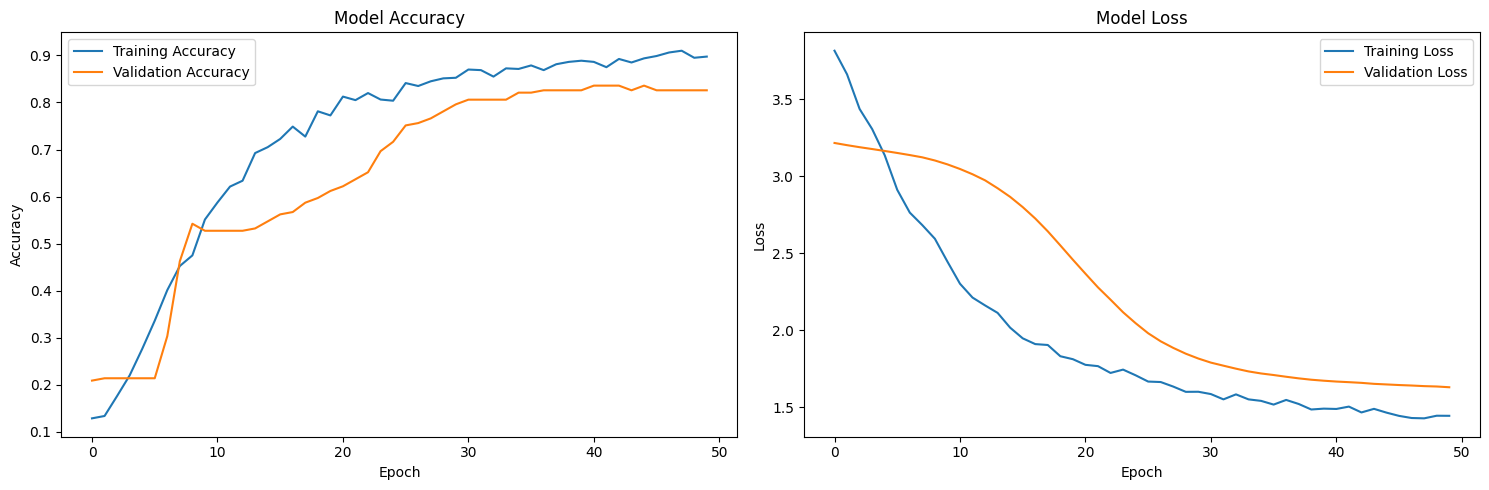

Training history visualization completed.


In [ ]:
# Section 7: Visualize Training History

import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Visualize the training history
plot_training_history(history)
print("Training history visualization completed.")

8/8 [==============================] - 1s 24ms/step

Classification Report:
              precision    recall  f1-score   support

    business       0.95      0.84      0.89        25
     culture       0.83      0.62      0.71         8
 environment       1.00      0.48      0.65        27
    politics       1.00      0.60      0.75        15
     science       0.80      0.57      0.67         7
       sport       0.95      1.00      0.97       105
  technology       0.00      0.00      0.00         4
       world       0.71      0.97      0.82        60

    accuracy                           0.86       251
   macro avg       0.78      0.64      0.68       251
weighted avg       0.88      0.86      0.85       251



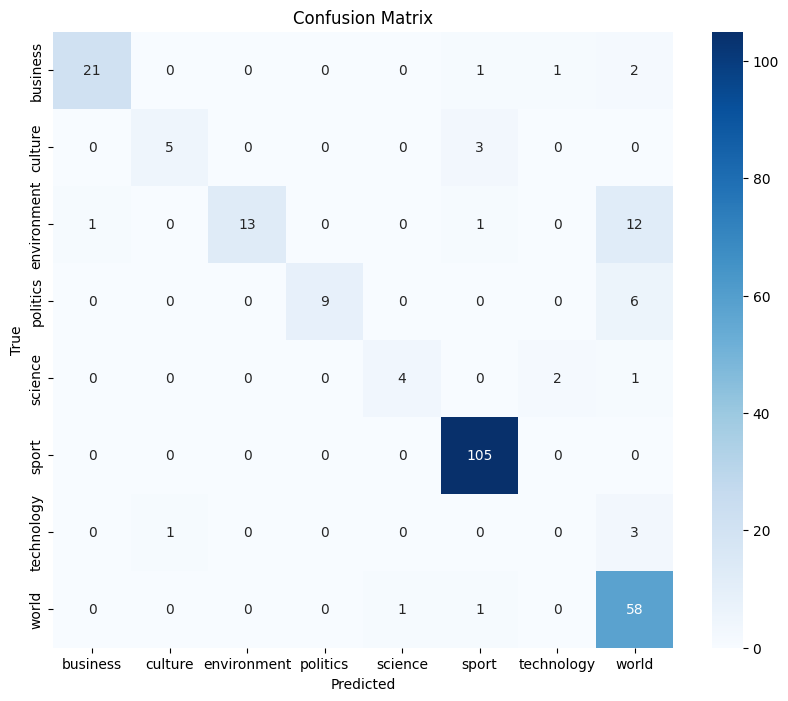

Model evaluation completed.


In [ ]:
# Section 8: Model Evaluation

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, X_test, y_test, label_encoder):
    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

    # Create and plot confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate the model
evaluate_model(model, X_test_pad, y_test_cat, label_encoder)
print("Model evaluation completed.")

In [ ]:
# Section 9: Save Model and Components

import pickle

def save_model_components(model, tokenizer, label_encoder):
    # Save the model
    model.save('guardian_article_classifier_final.h5')

    # Save the tokenizer
    with open('tokenizer_final.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Save the label encoder
    with open('label_encoder_final.pickle', 'wb') as handle:
        pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("Model, tokenizer, and label encoder saved.")

# Save the model and its components
save_model_components(model, tokenizer, label_encoder)

Model, tokenizer, and label encoder saved.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Section 10: Article Prediction Function

def predict_article_category(title, body, model, tokenizer, label_encoder):
    # Combine title and body
    text = f"{title} {body}"

    # Preprocess the text
    processed_text = preprocess_text(text)

    # Tokenize and pad the text
    text_seq = tokenizer.texts_to_sequences([processed_text])
    text_pad = pad_sequences(text_seq, maxlen=max_len)

    # Make prediction
    prediction = model.predict(text_pad)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = label_encoder.classes_[predicted_class_index]

    return predicted_class

# Test the prediction function
test_title = "New breakthrough in renewable energy"
test_body = "Scientists have discovered a revolutionary method to harness solar power, potentially solving the world's energy crisis."

predicted_category = predict_article_category(test_title, test_body, model, tokenizer, label_encoder)
print(f"Predicted category for the test article: {predicted_category}")

1/1 [==============================] - 0s 133ms/step
Predicted category for the test article: science
